## Question 1.2 K-Means and GMM

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from scipy.stats import multinomial, multivariate_t, multivariate_normal
np.random.seed(345)
def generate_dataset():
    
    num_points = 100  
    mu_a = [-1, -1]
    var_a = [[2, 0.5], [0.5, 1]]
    data_a = np.random.multivariate_normal(mu_a, var_a, num_points)
    mu_b = [1, -1]
    var_b = [[1, -0.5], [-0.5, 2]]
    data_b = np.random.multivariate_normal(mu_b, var_b, num_points)
    mu_c = [0, 1]
    var_c = [[1, 0], [0, 2]]
    data_c = np.random.multivariate_normal(mu_c, var_c, num_points)

    dataset = np.append(data_a, data_b, axis=0)
    dataset = np.append(dataset, data_c, axis=0)

    return dataset


In [207]:
# ds = generate_dataset()
# ds.shape
# ds

In [208]:



def k_means_clustering(X, k, max_iter=100):
    N = X.shape[0]
    
    centroids = X[np.random.choice(N, k, replace=False), :]        
    idx = np.zeros(N)
    for _ in range(max_iter):
      prev_centroids = centroids.copy()
      # Set each point to closest centroid
      for i, v in enumerate(X):
        # calculate the euclidean distance
        # print(centroids)
        distances = np.sum((X[i, :] - centroids)**2, axis=1) 
        # distances = euclideanDistance(X[i], centroids)
        idx[i] = np.argmin(distances) 

      #Centroid Update
      for j in range(k):
        centroids[j, :] = np.mean(X[idx == j, :], axis=0)

      if(np.allclose(centroids, prev_centroids, rtol=1e-05, atol=1e-08)):
        break

    intra_cluster_ss = 0
    inter_cluster_ss = 0
    for j in range(k):
        partial_sum = np.sum((X[idx == j, :] - centroids[j, :])**2)
        intra_cluster_ss += partial_sum
    
    for i in range(N):
      for j in range(i+1, N):
        if idx[i] != idx[j]:
          partial_sum = np.linalg.norm(X[i] - X[j])
          inter_cluster_ss += partial_sum

    labels = np.zeros(N)
    for j in range(k):
        labels[(idx == j)] = j

    true_labels = np.concatenate([np.zeros(N//3), np.ones(N//3), 2*np.ones(N//3)]).astype(int)
    accurate_instances = np.sum(labels == true_labels)
    acc_arr = accurate_instances / N

    return intra_cluster_ss, acc_arr, inter_cluster_ss



Text(0.5, 1.0, 'IntraCluster Sum Squares vs Sigma')

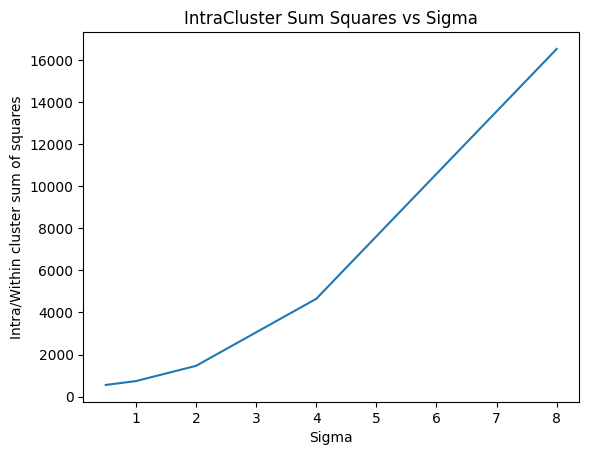

In [209]:

max_iter = 100
k = 3
prev_centroids = None
X = generate_dataset()
N = X.shape[0]

sig = [0.5, 1, 2, 4, 8]
intracluster_arr = np.zeros(5)
intercluster_arr = np.zeros(5)
acc_arr = np.zeros(5)


for i, s in enumerate(sig):
    X_noisy = X + np.random.normal(0, s, (N, 2))
   
    intracluster, acc, intercluster = k_means_clustering(X_noisy, k, max_iter)

    intracluster_arr[i] = intracluster
    acc_arr[i] = acc
    intercluster_arr[i] = intercluster

fig, ax = plt.subplots(1)


ax.plot(sig, intracluster_arr)
ax.set(xlabel='Sigma', ylabel='Intra/Within cluster sum of squares')
ax.set_title('IntraCluster Sum Squares vs Sigma')

Text(0.5, 1.0, 'InterCluster Sum Squares vs Sigma')

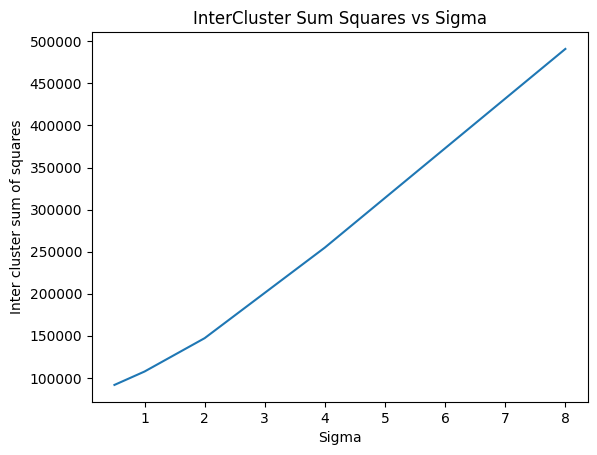

In [210]:
fig, ax = plt.subplots(1)


ax.plot(sig, intercluster_arr)
ax.set(xlabel='Sigma', ylabel='Inter cluster sum of squares')
ax.set_title('InterCluster Sum Squares vs Sigma')


Text(0.5, 1.0, 'Accuracy vs Sigma')

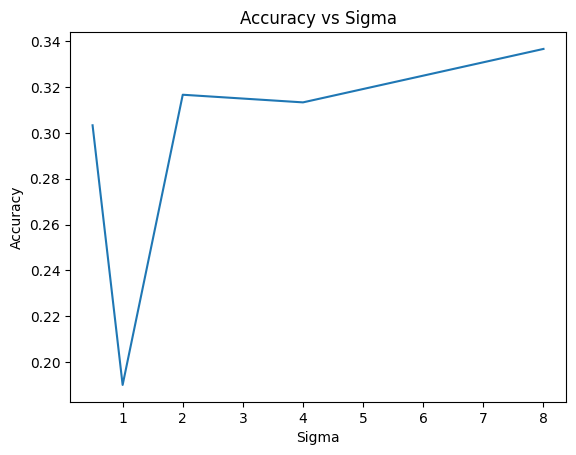

In [211]:
fig, ax = plt.subplots(1)


ax.plot(sig, acc_arr)
ax.set(xlabel='Sigma', ylabel='Accuracy')
ax.set_title('Accuracy vs Sigma')

In [268]:
def gaussian_mm(num_clusters, X, max_iter):
    
    pro = []
    for i in range(num_clusters):
        pro.append(1/num_clusters)
    ll = float('-inf')
    num_samples, num_features = X.shape
    mean = np.random.randn(num_clusters, num_features)
    covar = np.array([np.eye(num_features)] * num_clusters)
    pro = np.array(pro)
    for i in range(max_iter):
        ll_updated = 0
        gamma = np.zeros((num_samples, num_clusters))
        for j in range(num_clusters):
            distribution = multivariate_normal.pdf(X, mean[j], covar[j])
            gamma[:, j] = pro[j] * distribution
        gamma /= np.sum(gamma, axis=1, keepdims=True) 
        pro = np.sum(gamma, axis=0) / num_samples
        mean = (gamma.T @ X) / np.sum(gamma, axis=0)[:, np.newaxis]

        #Cmputing Maximisation
        for j in range(num_clusters):
            covar[j] = (gamma[:, j] * (X - mean[j]).T)@(X - mean[j]) / np.sum(gamma, axis=0)[j]   
        #Maximising lower bound
        for j in range(num_clusters):
            distribution = multivariate_normal.pdf(X, mean[j], covar[j])
            ll_updated += np.sum(gamma[:, j] * np.log(pro[j] * distribution))
        if ll_updated - ll > 1e-7:
            ll = ll_updated
            continue
        else:
            break
        

    return mean, covar, pro, gamma


In [269]:
def gmm_experiment(sigmas):
    
    n_sigma = len(sigmas)
    #takin running avg, say num_runs = 15
    num_runs = 15
    all_obj_scores = np.zeros((n_sigma, num_runs))
    all_acc_scores = np.zeros((n_sigma, num_runs))
    num_clusters = 3
    for i in range(len(sigmas)):
        for j in range(num_runs):
            X = generate_dataset()
            # print(X.shape[0])
            
            num_iter = 100
            pi, mean, sigma, r = gaussian_mm(num_clusters, X, num_iter)

            num_samples = X.shape[0]
            obj_score = 0
            for m in range(num_samples):
                for n in range(len(mean)):
                    obj_score += r[m, n] * np.linalg.norm(X[m] - mean[n], ord='fro')**2
            
            all_obj_scores[i, j] = obj_score
            # print(all_obj_scores)
            # Accuracy

            #print(weighted_probs)
            weighted_probs = r @ pi
            # print(weighted_probs)
            y_pred = np.argmax(weighted_probs, axis=1)
            y_true = np.concatenate((np.zeros(100), np.ones(100), 2*np.ones(100)))
            num_clusters = len(np.unique(y_true))
            
            accuracy = 0
            for m in range(num_clusters):
                label_max = float('-inf')
                for n in range(num_clusters):
                    diff = np.sum(np.logical_and(y_true == m, y_pred == n))
                    if diff > label_max:
                        label_max = diff
                        #print("label ", label_max)
                accuracy += label_max
            all_acc_scores[i, j] = accuracy/num_samples

    
    return all_obj_scores, all_acc_scores


In [284]:
sigmas = [0.5, 1, 2, 4, 8]
all_obj_scores, all_acc_scores = gmm_experiment(sigmas)
#print("Objective: ", all_obj_scores)
#print("Accuracy: ", all_acc_scores)

acc_mean = np.mean(all_acc_scores, axis=1)
acc_std = np.std(all_acc_scores, axis=1)

obj_mean = np.mean(all_obj_scores, axis=1)
obj_std = np.std(all_obj_scores, axis=1)

/var/folders/dt/4z_884k92lngr1mqr9y284q40000gn/T/ipykernel_78333/1126816439.py:27: RuntimeWarning: divide by zero encountered in log
  ll_updated += np.sum(gamma[:, j] * np.log(pro[j] * distribution))


Text(0.5, 1.0, 'Objective vs Sigma')

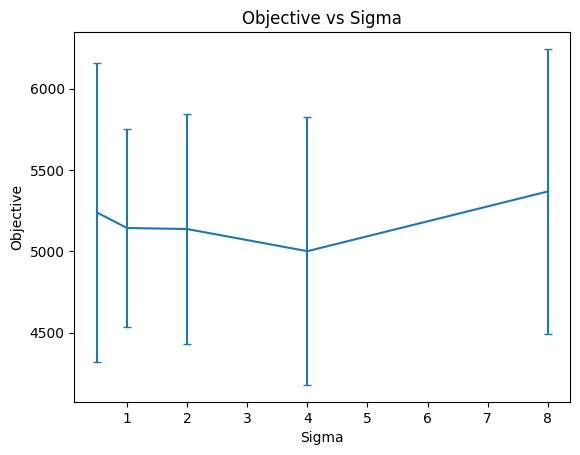

In [292]:
fig, ax = plt.subplots(1)

ax.errorbar(sigmas, obj_mean, yerr=obj_std, capsize=3, fmt='-')
ax.set(xlabel='Sigma', ylabel='Objective')
ax.set_title('Objective vs Sigma')




Text(0.5, 1.0, 'Accuracy vs Sigma')

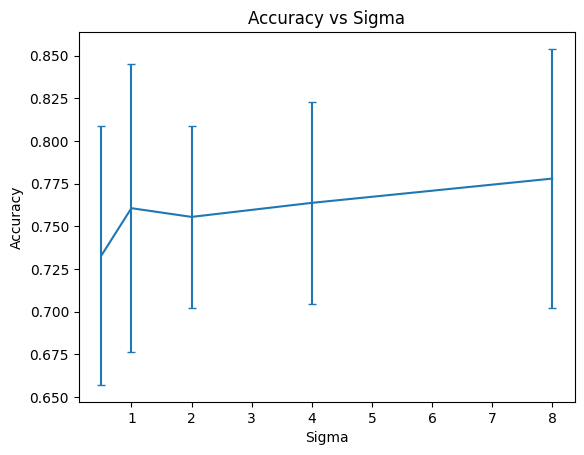

In [294]:
fig, ax = plt.subplots(1)

ax.errorbar(sigmas, acc_mean, yerr=acc_std, capsize=3, fmt='-')
ax.set(xlabel='Sigma', ylabel='Accuracy')
ax.set_title('Accuracy vs Sigma')




## Question 2.3 PCA 

In [319]:
def buggy_pca(X, d=1): 
    _, _, Vt = np.linalg.svd(X)
    V = Vt.T
    Z = X.dot(V[:, :d])
    reconstruction = Z@(V[:, :d].T)
    return Z, V[:, :d], reconstruction

def demeaned_pca(X, d=1):
    X_mu = np.mean(X, axis=0)
    X_deam = X - X_mu
    _, _, Vt = np.linalg.svd(X_deam)
    V = Vt.T
    Z = X_deam.dot(V[:, :d])
    reconstruction = Z@(V[:, :d].T) + X_mu
    return Z, V[:, :d], reconstruction

def normalized_pca(X, d=1):
    X_mu = np.mean(X, axis=0)
    X_var = np.std(X, axis=0)
    X_standardize = (X - X_mu) / X_var
    _, _, Vt = np.linalg.svd(X_standardize)
    V = Vt.T
    Z = X_standardize.dot(V[:, :d])
    reconstruction = (Z@(V[:, :d].T)) * X_var + X_mu
    return Z, V[:, :d], reconstruction

X_pd = pd.read_csv('data/data2D.csv', delimiter=',', header=None)
X = X_pd.to_numpy()
print(X_pd.shape, X.shape)

_, _, recon_buggy = buggy_pca(X, 1)
mean_recon_buggy = np.mean(np.sum(np.square(X - recon_buggy), axis=1))

_, _, recon_demeaned = demeaned_pca(X, 1)
mean_recon_demeaned = np.mean(np.sum(np.square(X - recon_demeaned), axis=1))

_, _, recon_normalized = normalized_pca(X, 1)
mean_recon_normalized = np.mean(np.sum(np.square(X - recon_normalized), axis=1))

print("Buggy PCA: ", mean_recon_buggy)
print("Demean PCA:", mean_recon_demeaned)
print("Normalized PCA:", mean_recon_normalized)


(50, 2) (50, 2)
Buggy PCA:  0.8869030837347942
Demean PCA: 0.010006085628512913
Normalized PCA: 0.04947208345477067


In [335]:
import cvxpy as cp

def dro_pca2(X, d):
    
    
    # n_samples, n_features = X.shape[0], X.shape[1]

    # Apply PCA to the data to obtain the low-dimensional representation Z
    _, _, V_d = np.linalg.svd(X, full_matrices=False)
    V_d = V_d[:d, :]
    Z = np.dot(X, V_d.T)

    # Define the DRO problem
    n, D = X.shape

    # Create optimization variables
    z = cp.Variable((n, d))
    A = cp.Parameter((n, D))
    b = cp.Parameter((D,d))
    alpha = cp.Parameter(nonneg=True)

    # Define the uncertainty set
    print(A.shape, z.shape, b.shape)
    uncertainty = cp.norm(A.T @ z + b)

    # Define the objective function
    objective = cp.Maximize(cp.sum(cp.log(1 - alpha * uncertainty)))

    # Create the optimization problem
    problem = cp.Problem(objective)

    # Define parameters for DRO
    A_value = np.random.randn(n, D)
    b_value = np.random.randn(D, d)
    alpha_value = 0.1  # Adjust the value of alpha as needed

    # Set parameter values
    A.value = A_value
    b.value = b_value
    alpha.value = alpha_value

    # Solve the DRO problem
    problem.solve()

    # Extract the optimal solution
    optimal_Z = z.value

    # Reconstruct the data in D dimensions
    reconstructed_X = np.dot(optimal_Z, V_d)
    recon_error = np.mean(np.sum(np.square(X - reconstructed_X), axis=1))
    return Z, reconstructed_X, recon_error
    # 'reconstructed_X' contains the data reconstructed using DRO with PCA

def dro_pca(X, d):
    
    X_centered = X - np.mean(X, axis=0)
    cov_mat = np.cov(X_centered, rowvar=False)
    eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

    sorted_indices = np.argsort(eigen_vals)[::-1]
    sorted_eigen_vals = eigen_vals[sorted_indices]
    sorted_eigen_vecs = eigen_vecs[:, sorted_indices]

    projection_mat = sorted_eigen_vecs[:, :d]

    Z = X_centered.dot(projection_mat)

    recons = Z.dot(projection_mat.T) + np.mean(X, axis=0)


    return Z, projection_mat, recons

X_pd = pd.read_csv('data/data2D.csv', delimiter=',', header=None)
X = X_pd.to_numpy()
print(X_pd.shape, X.shape)
_, _, recons = dro_pca(X, 1)
mean_recon_dro = np.mean(np.sum(np.square(X - recons), axis=1))
_, _, recon_error2 = dro_pca2(X, 1)
# print('Reconstruction Error (DRO):', recon_error2)
print('Reconstruction Error (DRO):', mean_recon_dro)



(50, 2) (50, 2)
(50, 2) (50, 1) (2, 1)
Reconstruction Error (DRO): 0.010006085628512906


/Users/agamdwivedi/opt/anaconda3/envs/ass1/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)
/Users/agamdwivedi/opt/anaconda3/envs/ass1/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Text(0.5, 1.0, 'Buggy PCA Plot')

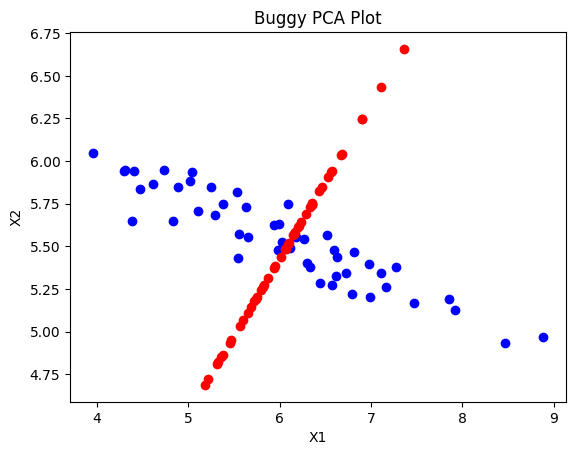

In [322]:
fig, ax = plt.subplots(1)
ax.scatter(X[:,0], X[:,1], color='blue', label="Original Data Points")
ax.scatter(recon_buggy[:,0], recon_buggy[:, 1], color='red', label="Reconstructed Buggy Result")
ax.set(xlabel='X1', ylabel='X2')
ax.set_title('Buggy PCA Plot')

Text(0.5, 1.0, 'Demeaned PCA Plot')

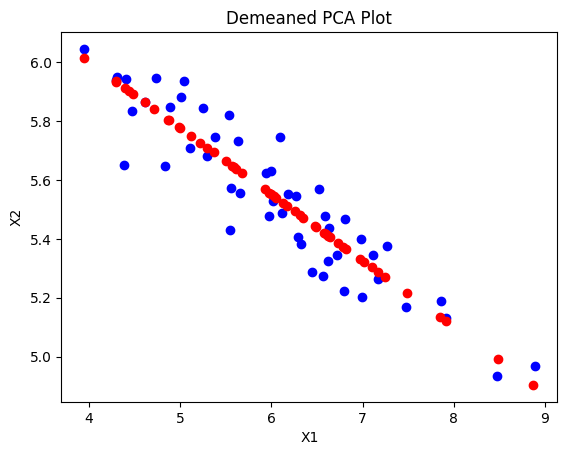

In [323]:
fig, ax = plt.subplots(1)
ax.scatter(X[:,0], X[:,1], color='blue', label="Original Data Points")
ax.scatter(recon_demeaned[:,0], recon_demeaned[:, 1], color='red', label="Reconstructed Demeaned Result")
ax.set(xlabel='X1', ylabel='X2')
ax.set_title('Demeaned PCA Plot')

Text(0.5, 1.0, 'Normalized PCA Plot')

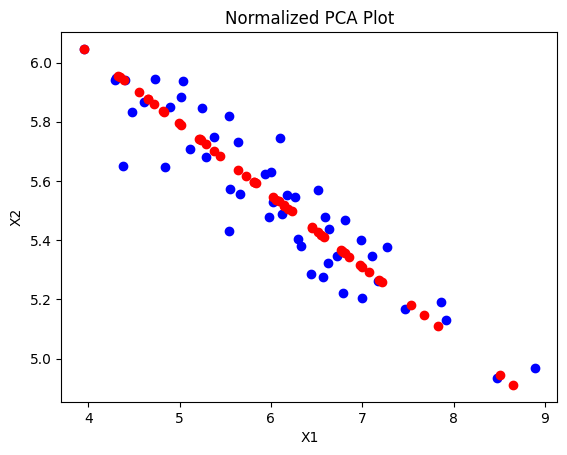

In [324]:
fig, ax = plt.subplots(1)
ax.scatter(X[:,0], X[:,1], color='blue', label="Original Data Points")
ax.scatter(recon_normalized[:,0], recon_normalized[:, 1], color='red', label="Reconstructed Normalized Result")
ax.set(xlabel='X1', ylabel='X2')
ax.set_title('Normalized PCA Plot')

Text(0.5, 1.0, 'DRO PCA Plot')

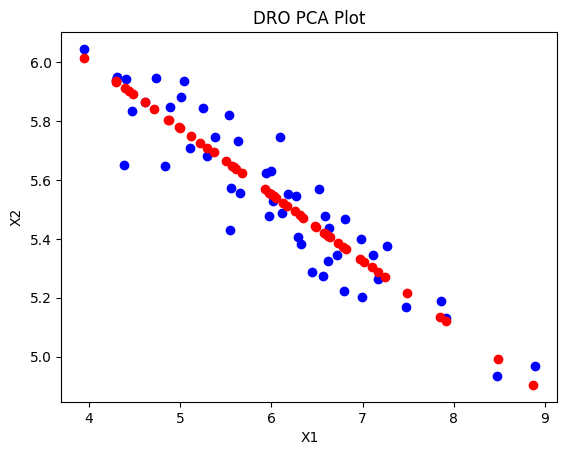

In [336]:
fig, ax = plt.subplots(1)
ax.scatter(X[:,0], X[:,1], color='blue', label="Original Data Points")
ax.scatter(recons[:,0], recons[:, 1], color='red', label="Reconstructed DRO Result")
ax.set(xlabel='X1', ylabel='X2')
ax.set_title('DRO PCA Plot')

(500, 1000) (500, 1000)
best dimension parameter :  433


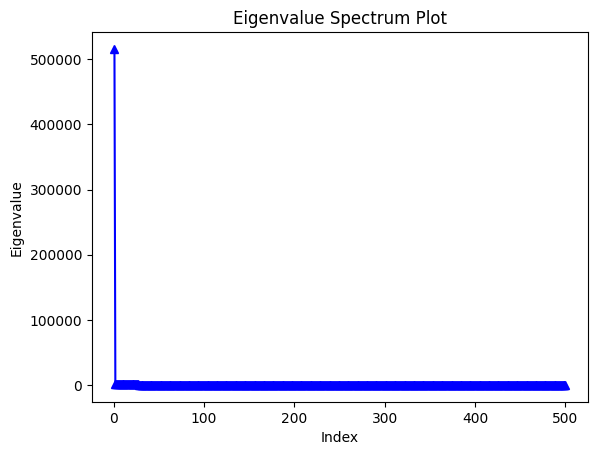

In [330]:
X_pd = pd.read_csv('data/data1000D.csv', delimiter=',', header=None)
X = X_pd.to_numpy()
print(X_pd.shape, X.shape)

U, S, Vt = np.linalg.svd(X, full_matrices=False)
eigen_values = S**2 / (X.shape[0] - 1)
eigen_values_sorted = np.sort(eigen_values)[::-1]

x_ind = np.arange(1, len(eigen_values)+1)
fig, ax = plt.subplots(1)
ax.plot(x_ind, eigen_values_sorted, 'b^-')
ax.set(xlabel='Index', ylabel='Eigenvalue')
ax.set_title('Eigenvalue Spectrum Plot')

diffs = np.diff(eigen_values_sorted)
knee_index = np.argmax(diffs) + 1

d = knee_index

print("best dimension parameter : ", d)

## 1000D Dataset reconstruction

In [337]:
X_pd = pd.read_csv('data/data1000D.csv', delimiter=',', header=None)
X = X_pd.to_numpy()
print(X_pd.shape, X.shape)
# Compute reconstruction errors for each method
d = 433
_, _, recon_buggy = buggy_pca(X, d)
mean_recon_buggy = np.mean(np.sum(np.square(X - recon_buggy), axis=1))

_, _, recon_demeaned = demeaned_pca(X, d)
mean_recon_demeaned = np.mean(np.sum(np.square(X - recon_demeaned), axis=1))

_, _, recon_normalized = normalized_pca(X, d)
mean_recon_normalized = np.mean(np.sum(np.square(X - recon_normalized), axis=1))

print("Buggy PCA: ", mean_recon_buggy)
print("Demean PCA:", mean_recon_demeaned)
print("Normalized PCA:", mean_recon_normalized)


(500, 1000) (500, 1000)
Buggy PCA:  7.3196687099544215
Demean PCA: 7.180926411793021
Normalized PCA: 7.4910582302559625


In [338]:
X_pd = pd.read_csv('data/data1000D.csv', delimiter=',', header=None)
X = X_pd.to_numpy()
print(X_pd.shape, X.shape)
_, _, recons = dro_pca(X, d)
mean_recon_dro = np.mean(np.sum(np.square(X - recons), axis=1))
# _, _, recon_error2 = dro_pca2(X, 1)
# print('Reconstruction Error (DRO):', recon_error2)
print('Reconstruction Error (DRO):', mean_recon_dro)

(500, 1000) (500, 1000)
Reconstruction Error (DRO): (7.180926411793021+0j)
